In [3]:
!pip install gymnasium highway-env stable-baselines3[extra]

^C


In [2]:
import gymnasium as gym
# import highway_env
# highway_env.register_highway_envs()

import time
import numpy as np
import pandas as pd
from collections import deque
from tqdm.notebook import tqdm
import itertools
import pickle
import random
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

# from stable_baselines3 import DQN
# from stable_baselines3.common.callbacks import CheckpointCallback
# from stable_baselines3.common.monitor import Monitor

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from scipy.signal import convolve, gaussian
import tensorflow as tf

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print('func:%r took: %2.4f sec' % \
          (f.__name__, te-ts))
        return result

    return timed

action_names = ['left', 'idle', 'right', 'faster', 'slower']

In [4]:
default_config = {
    "lanes_count" : 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "collision_reward": -200,
    "right_lane_reward": 5,
    "high_speed_reward": 20,
    "lane_change_reward": 3,
    "reward_speed_range": [20, 30],
    "normalize_reward": False,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}

In [5]:
class TimeToCollisionVec:
    def __init__(self, 
                num_envs=1, 
                horizon=5,
                policy_frequency=5,
                simulation_frequency=15,
                collision_reward=-200,
                high_speed_reward=10,
                right_lane_reward=10,
                lane_change_reward=-1,
                obs_type='speed-restricted',
                string_shaped=True,
                config=None,
                ):
        """
        Constructor for the TimeToCollisionVec class.
        Args:
            num_envs: Number of parallel environments to run.
            horizon: The number of timesteps to look ahead for the TimeToCollision observation.
            policy_frequency: The frequency at which the policy is evaluated.
            simulation_frequency: The frequency at which the simulation is run.
            high_speed_reward: The reward given for driving at high speed.
            right_lane_reward: The reward given for driving in the right lane.
            lane_change_reward: The reward given for changing lanes.
            obs_type: The type of observation to use. Choose from 'normal' or 'speed-restricted'
                'normal': The normal TimeToCollision observation (x3 different speeds the car could be at)
                'speed-restricted': Only one of the TimeToCollision observations is used (the speed the car is currently at) (less complex observation space)
            string_shaped: Whether to return the observation as a string shape (num_envs, dim1*dim2*dim3*...) or not (num_envs, dim1, dim2, dim3, ...)
        """
        assert obs_type in ['normal', 'speed-restricted'], "obs_type must be either 'normal' or 'speed-restricted'"
        if obs_type == 'speed-restricted' and not string_shaped:
            raise ValueError("If obs_type is 'speed-restricted', string_shaped must be True")
        
        self.config = default_config.copy()
        self.config["observation"] =  {
                "type": "TimeToCollision",
                "horizon": horizon}
        self.horizon = horizon

        self.config.update({
            "policy_frequency": policy_frequency,
            "simulation_frequency": simulation_frequency,
            "high_speed_reward": high_speed_reward,
            "right_lane_reward": right_lane_reward,
            "lane_change_reward": lane_change_reward,
            "collision_reward": collision_reward,
        })

        if config is not None:
            self.config.update(config)
        
        self.num_envs = num_envs
        self.obs_type = obs_type
        self.string_shaped = string_shaped

        with gym.make("highway-fast-v0", config=self.config) as env:
            self.env = gym.vector.AsyncVectorEnv([lambda: env for _ in range(num_envs)])
            self.obs_space_shape = env.observation_space.shape if not obs_type == 'speed-restricted' else (env.observation_space.shape[1:])
            self.action_space_size = env.action_space.n

    def get_speeds(self):
        return [car.speed_index for car in self.env.get_attr('vehicle')]
    
    def get_state(self, obs):
        observation = np.array(obs)
        if self.obs_type == 'speed-restricted':
            speed_indices = self.get_speeds()
            observation =  np.array([observation[i][speed_indices[i]] for i in range(self.num_envs)])
        if self.string_shaped:
            # Convert the observation to a string shape: from (num_envs, dim1, dim2, dim3, ...) to (num_envs, dim1*dim2*dim3*...)
            observation = observation.reshape((self.num_envs, -1))
        return observation
    
    def reset(self, seeds=None):
        if seeds is None:
            seeds = [np.random.randint(100000) for _ in range(self.num_envs)]
        obs, info = self.env.reset(seed=seeds)
        return self.get_state(obs)
        
    def step(self, actions, string_shaped=False):
        obs, rewards, dones, truncates, info = self.env.step(actions)
        return self.get_state(obs), np.array(rewards), np.array(dones), np.array(truncates)
    
    def close(self):
        self.env.close()    

    def action_space_sample(self):  
        return self.env.action_space.sample()

In [6]:
class TimeToCollision:
    def __init__(self, 
                horizon=5,
                policy_frequency=5,
                simulation_frequency=15,
                high_speed_reward=10,
                right_lane_reward=10,
                lane_change_reward=-1,
                collision_reward=-200,
                render_mode=None,
                obs_type='speed-restricted', 
                string_shaped=True, 
                config=None):
        
        assert obs_type in ['normal', 'speed-restricted'], "obs_type must be either 'normal' or 'speed-restricted'"
        if obs_type == 'speed-restricted' and not string_shaped:
            raise ValueError("If obs_type is 'speed-restricted', string_shaped must be True")

        self.config = default_config.copy()
        self.config["observation"] =  {
                "type": "TimeToCollision",
                "horizon": horizon}
        self.horizon = horizon
        self.obs_type = obs_type
        self.string_shaped = string_shaped

        self.config.update({
            "policy_frequency": policy_frequency,
            "simulation_frequency": simulation_frequency,
            "high_speed_reward": high_speed_reward,
            "right_lane_reward": right_lane_reward,
            "lane_change_reward": lane_change_reward,
            "collision_reward": collision_reward,
        })

        if config is not None:
            self.config.update(config)

        with gym.make("highway-fast-v0", config=self.config, render_mode=render_mode) as env:
            self.env = env
            self.obs_space_shape = env.observation_space.shape if not string_shaped else env.observation_space.shape[1:]
            self.action_space_size = env.action_space.n

    def get_speed(self):
        return self.env.get_wrapper_attr('vehicle').speed_index

    def get_state(self, obs):
        observation = np.array(obs)
        if self.obs_type == 'speed-restricted':
            speed_index = self.get_speed()
            observation = observation[speed_index]
        if self.string_shaped:
            observation = observation.flatten()
        return observation

    def reset(self, seed='random'):
        if seed == 'random':
            seed = np.random.randint(100000)
        obs, info = self.env.reset(seed=seed)
        return self.get_state(obs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        return self.get_state(obs), reward, done, truncated

    def close(self):
        self.env.close()

    def action_space_sample(self):
        return self.env.action_space.sample()

    def test_env(self, sleep_time=1):
        with gym.make("highway-v0", config=self.config, render_mode='human') as env:
            self.env = env
            obs = env.reset()
            for _ in range(1000):
                action = env.action_space.sample()
                obs, reward, done, truncated, info = env.step(action)
                print(self.get_state(obs), reward)
                if done:
                    break
                time.sleep(sleep_time)

In [7]:
def CNN(obs_space_shape, action_space_size):
    model = Sequential()
    model.add(Conv2D(64, (2, 2), input_shape=obs_space_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Dropout(0.2))

    model.add(Dense(action_space_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

def CNN_2(obs_space_shape, action_space_size):
    init = tf.keras.initializers.HeUniform()
    model = Sequential()
    model.add(Conv2D(64, (2, 2), input_shape=obs_space_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Dropout(0.2))

    model.add(Dense(action_space_size, activation='linear'))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model


def NN_1(obs_space_shape, action_space_size):
    init = tf.keras.initializers.HeUniform()
    # Make the multiplication in the obs space shape tuple 
    obs_size = (np.prod(obs_space_shape),)
    model = Sequential()
    model.add(Dense(32, input_shape=obs_size, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(action_space_size, activation='linear'))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

def NN_2(obs_space_shape, action_space_size):
    init = tf.keras.initializers.HeUniform()
    # Make the multiplication in the obs space shape tuple 
    obs_size = (np.prod(obs_space_shape),)
    model = Sequential()
    model.add(Dense(128, input_shape=obs_size, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(action_space_size, activation='linear'))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [8]:
class DQNAgent:
    def __init__(self, 
                 env,
                 model_type='CNN'):
        assert not (model_type in ['CNN','CNN_2'] and (env.obs_type == 'speed-restricted' or env.string_shaped)), 'CNN model cannot be used with speed-restricted observation type'
        self.env = env
        self.model_type = model_type
        self.initialized = False

        # Main model - what gets trained every step
        self.model = self.create_model()
        print('Model Stats:')
        print(self.model.summary())
        print(self.model.input_shape)

        # Target model - what we predict every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        self.target_update_counter = 0

    def create_model(self):
        if self.model_type == 'CNN':
            return CNN(self.env.obs_space_shape, self.env.action_space_size)
        elif self.model_type == 'NN_1':
            return NN_1(self.env.obs_space_shape, self.env.action_space_size)
        elif self.model_type == 'CNN_2':
            return CNN_2(self.env.obs_space_shape, self.env.action_space_size)
        elif self.model_type == 'NN_2':
            return NN_2(self.env.obs_space_shape, self.env.action_space_size)
        
    def init(self, epsilon=1,
             min_eps=0.001,
             eps_decay=0.998,
             gamma=0.99,
             alpha=0.75,
             replay_memory=50_000,
             batch_size=64,
             update_weights_freq=100,
             train_model_freq=5,
             min_replay_memory=1_000
             ):
        self.initialized = True
        self.epsilon, self.min_eps, self.eps_decay = epsilon, min_eps, eps_decay
        self.replay_memory = deque(maxlen=replay_memory)
        self.update_weights_freq, self.train_model_freq = update_weights_freq, train_model_freq
        self.min_replay_memory = min_replay_memory
        self.batch_size = batch_size
        self.gamma, self.alpha = gamma, alpha
        self.current_episode, self.step = 0, 0
        self.mean_rw_history, self.mean_steps_history, self.loss_hist, self.action_distribution_history = [], [], [], []
        self.current_best_reward = 0
        self.action_crossentropy_hist = []

    def update_replay_memory(self, transition):
        self.replay_memory.extend(transition)

    def get_qs(self, state):
        return self.model.predict(state, verbose=0)

    def train_model(self, terminal_state):
        if len(self.replay_memory) < self.min_replay_memory:
            return

        minibatch = random.sample(self.replay_memory, self.batch_size)

        current_states = np.array([transition[0] for transition in minibatch])
        # The model that gets trained every step
        current_qs_list = self.get_qs(current_states)

        new_current_states = np.array([transition[3] for transition in minibatch])
        # The model that doesn't get trained every step
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X,y = [], []

        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            new_q = reward

            if not done:
                # In case of a non-terminal state, add future reward
                max_future_q = np.max(future_qs_list[index])
                new_q += self.gamma * max_future_q

            # Update the q value for the action taken (using the Bellman equation)
            current_qs = current_qs_list[index]
            current_qs[action] = (1-self.alpha)*current_qs[action] + self.alpha*new_q
            
            X.append(current_state)
            y.append(current_qs)

        history = self.model.fit(np.array(X), np.array(y), batch_size=self.batch_size, verbose=0, shuffle=False)

        # If counter reaches set value, update target network with weights of main network
        if self.step % self.update_weights_freq == 0:
            self.target_model.set_weights(self.model.get_weights())

        return history.history['loss'][0] 

    def epsilon_greedy(self,current_state):
        if np.random.random() > self.epsilon:
            action = np.argmax(self.get_qs(current_state), axis=1)
        else:
            # Generate self.env.num_envs random actions
            action = self.env.action_space_sample()
        return np.array(action)

    def decay_eps(self):
        if self.epsilon > self.min_eps:
            self.epsilon *= self.eps_decay
            self.epsilon = max(self.min_eps, self.epsilon)

    def train(self, episodes=10_000, episode_duration=200, evaluation_freq=25, tolerance=10):
        if not self.initialized:
          print('Warning! Initializing with default parameters')
          self.init()

        start_time = time.time()
        tollerance_counter = 0
        for episode in tqdm(range(self.current_episode, episodes), unit='episode'):
            current_states = self.env.reset()
            self.current_episode += 1
            
            count = 0
            # Episode cycle
            while count < episode_duration:
                action = self.epsilon_greedy(current_states)
                new_states, rewards, done, truncate = self.env.step(action)
                done = done | truncate
                
                to_append = list(zip(current_states, action, rewards, new_states, done))
                self.update_replay_memory(to_append)

                if self.step % self.train_model_freq == 0:
                    loss = self.train_model(False)
                    self.loss_hist.append(loss) if loss is not None else None

                current_states = new_states
                self.step += 1
                count += 1

            loss = self.train_model(True)
            self.loss_hist.append(loss) if loss is not None else None

            if self.current_episode % evaluation_freq == 0:
                rewards_mean, steps_mean, action_distribution = self.evaluate(n_games=10, steps=120)
                self.mean_rw_history.append(rewards_mean)
                self.mean_steps_history.append(steps_mean)
                self.action_distribution_history.append(action_distribution)
                action_cross_entropy = -np.sum(action_distribution * np.log(action_distribution + 1e-6))
                self.action_crossentropy_hist.append(action_cross_entropy)

                # If the model is better than the previous best, save it
                if rewards_mean > self.current_best_reward:
                    self.model.save(f'models/{self.model_type}_best_{self.current_episode}_{np.random.randint(100000)}.h5')
                    self.current_best_reward = rewards_mean
                
                else:
                    tollerance_counter += 1

                clear_output(wait=True)

                print(f"episode = {self.current_episode}, epsilon = {self.epsilon}, mean reward = {rewards_mean}, mean steps = {steps_mean}")
                print(f"total steps = {self.step*self.env.num_envs}, time_elapsed = {time.time() - start_time}, fps = {self.step*self.env.num_envs / (time.time() - start_time)}")
                
                plt.figure(figsize=[16, 10])
                plt.suptitle(f"Stats for episode {self.current_episode} with params:\ncollision_reward = {self.env.config['collision_reward']}, right_lane_reward = {self.env.config['right_lane_reward']}, high_speed_reward = {self.env.config['high_speed_reward']}, lane_change_reward = {self.env.config['lane_change_reward']}")
                plt.subplot(2, 2, 1)
                plt.title("Mean reward per episode")
                plt.plot(self.mean_rw_history)
                plt.grid()

                plt.subplot(2, 2, 2)
                plt.title("Mean steps per episode")
                plt.plot(self.mean_steps_history)
                plt.grid()

                plt.subplot(2, 2, 3)
                plt.title("Action distribution for the current episode")
                plt.bar(action_names, action_distribution)
                plt.grid()

                plt.subplot(2, 2, 4)
                plt.title("Action cross-entropy history (higher is better) means more diverse actions")
                plt.plot(self.action_crossentropy_hist)
                plt.grid()
                plt.show()

            # If the 10 last rewards didn't improve at all, stop training
            if tollerance_counter >= tolerance:
                print(f'Tollerance reached! Stopping training at episode {self.current_episode}')
                break
            self.decay_eps()

    def get_evaluation_config(self):
        config = self.env.config.copy()
        config.update({
                "collision_reward": -1,
                "right_lane_reward": 0.1,
                "high_speed_reward": 0.4,
                "lane_change_reward": 0, 
                "reward_speed_range": [20, 30],
        })
        return config

    def evaluate(self, n_games=3, steps=200, verbose=True):
        horizon = self.env.horizon
        ttc_vec_env = TimeToCollisionVec(num_envs=n_games, horizon=horizon, config=self.get_evaluation_config())

        print('Evaluating...') if verbose else None
        total_reward, finished_games = 0, 0
        obs = ttc_vec_env.reset()
        actions_hist = []
        for _ in range(steps):
            actions = np.argmax(self.get_qs(obs), axis=1)
            actions_hist.extend(actions)
            obs, rewards_, dones, _ = ttc_vec_env.step(actions)
            total_reward += rewards_.sum()
            finished_games += dones.sum()

        total_steps = steps * n_games
        average_reward = total_reward / (n_games + finished_games)
        average_steps = total_steps /  (n_games + finished_games)
        # Calculate the action distribution
        actions_hist = np.array(actions_hist)
        action_distribution = np.array([np.sum(actions_hist == i) for i in range(ttc_vec_env.action_space_size)]) / len(actions_hist)
        ttc_vec_env.close()        
        return average_reward, average_steps, action_distribution


    def evaluate_and_render(self, n_games=3, steps=200, verbose=True):
        horizon = self.env.horizon
        ttc_env = TimeToCollision(horizon=horizon, render_mode='human', config=self.get_evaluation_config())

        print('Evaluating...') if verbose else None
        rewards, steps_array, actions_hist = [], [], []
        for i in tqdm(range(n_games)):
            cum_reward = 0
            step, done = 0, False
            current_state = ttc_env.reset(seed=np.random.randint(100000+i))
            while not done and step < steps:
                # Get next action
                next_action = np.argmax(self.get_qs(current_state.reshape(1, *current_state.shape)))
                actions_hist.append(next_action)
                current_state, reward, done, truncated = ttc_env.step(next_action)
                done = done | truncated
                cum_reward += reward
                step += 1
            rewards.append(cum_reward)
            steps_array.append(step)
        actions_hist = np.array(actions_hist)
        action_distribution = np.array([np.sum(actions_hist == i) for i in range(ttc_env.action_space_size)]) / len(actions_hist)

        ttc_env.close()
        return np.mean(rewards), np.mean(steps_array), action_distribution

episode = 110, epsilon = 0.4166508429471817, mean reward = 18.099846585460725, mean steps = 48.0
total steps = 55000, time_elapsed = 6221.918667554855, fps = 8.83971696493011


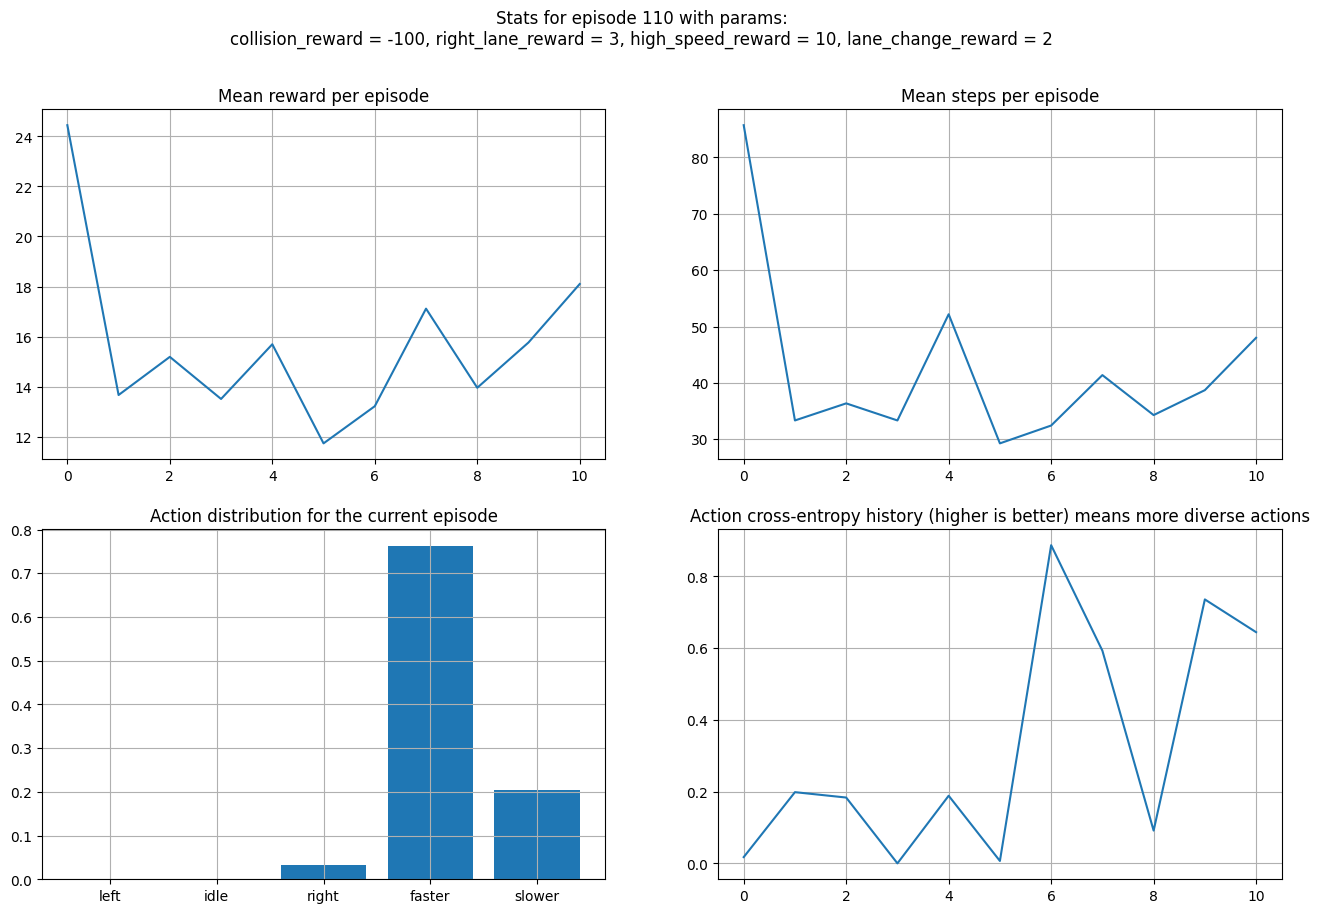

Tollerance reached! Stopping training at episode 110


In [8]:
ttc_vec = TimeToCollisionVec(num_envs=10, 
                            horizon=5,
                            policy_frequency=3, 
                            simulation_frequency=20,
                            collision_reward=-100,
                            high_speed_reward=10, 
                            right_lane_reward=3, 
                            lane_change_reward=2,
                            obs_type='speed-restricted', 
                            string_shaped=True)

agent = DQNAgent(ttc_vec, model_type='NN_2')
agent.init(
    epsilon=1,
    min_eps=0.01,
    eps_decay=0.992,  #.998
    gamma=0.99,
    alpha=0.3,
    replay_memory=50_000,  #50_000
    batch_size=64,   # 64
    train_model_freq=10,
    update_weights_freq=150,
    min_replay_memory=1_000, # 1_000
)

agent.train(episodes=400,
            episode_duration=50,  # 50
            evaluation_freq=10,  # 10
            tolerance=10)

episode = 590, epsilon = 0.05327239673939179, mean reward = 10.417153336485619, mean steps = 29.26829268292683
total steps = 118000, time_elapsed = 2813.014227628708, fps = 41.9478859513166


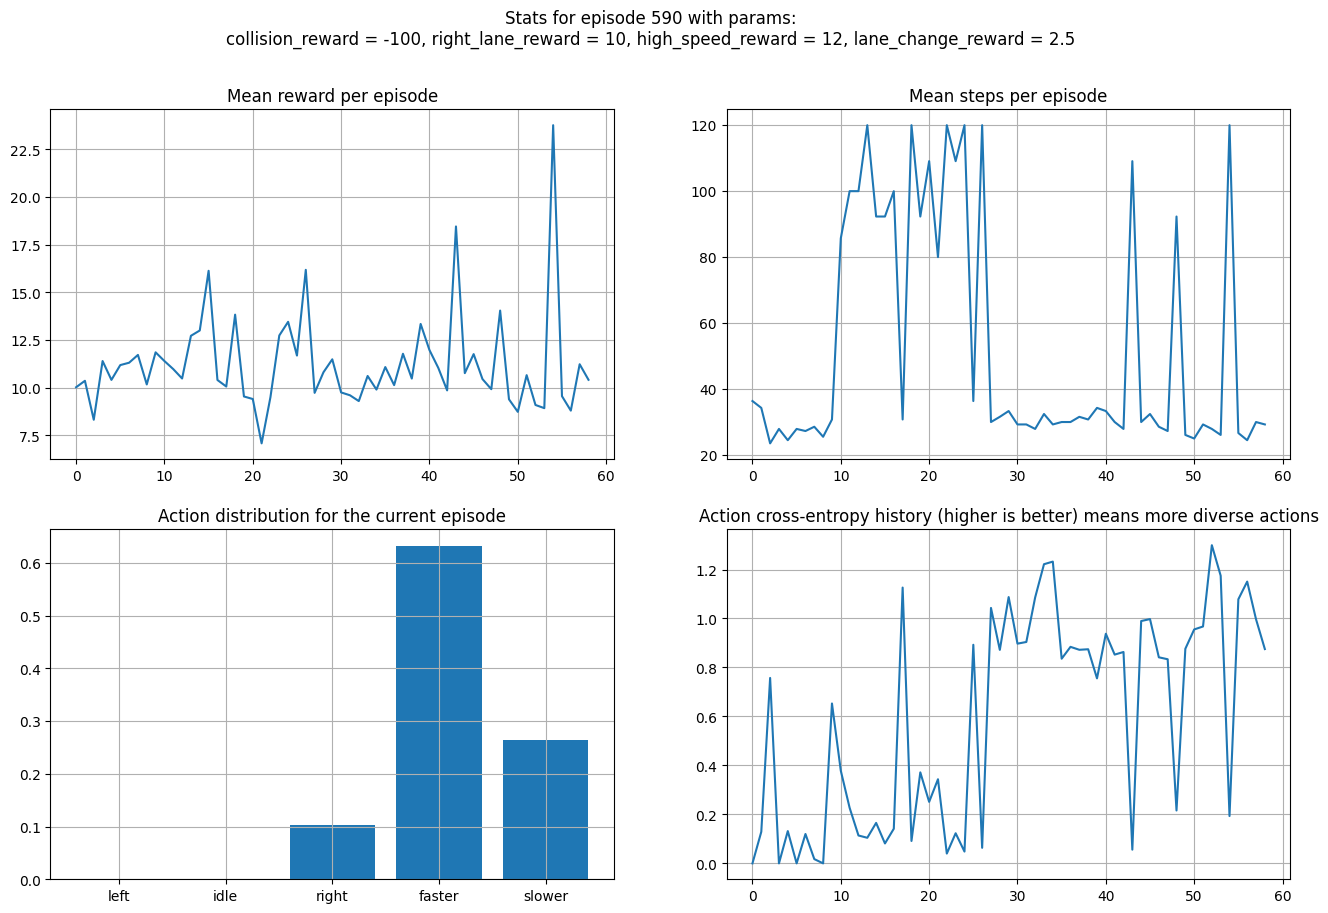

In [15]:
# # MORE REWARD, LESS ALPHA
# ttc_vec_2 = TimeToCollisionVec(num_envs=10, 
#                             horizon=6,
#                             policy_frequency=3, 
#                             simulation_frequency=20,
#                             collision_reward=-100,
#                             high_speed_reward=12, 
#                             right_lane_reward=10, 
#                             lane_change_reward=2.5,
#                             obs_type='speed-restricted', 
#                             string_shaped=True)

# agent_2 = DQNAgent(ttc_vec_2, model_type='NN_2')
# agent_2.init(
#     epsilon=1,
#     min_eps=0.01,
#     eps_decay=0.995,  #.998
#     gamma=0.99,
#     alpha=0.05,
#     replay_memory=50_000,  #50_000
#     batch_size=32,   # 64
#     train_model_freq=4,
#     update_weights_freq=100,
#     min_replay_memory=1_000, # 1_000
# )

agent_2.train(episodes=1_000,
            episode_duration=20,
            evaluation_freq=10)

In [12]:
agent_2.evaluate_and_render(n_games=3, steps=200)

Evaluating...


  0%|          | 0/3 [00:00<?, ?it/s]

(28.44811847023584,
 70.0,
 array([0.        , 0.        , 0.06666667, 0.76190476, 0.17142857]))

In [ ]:
ttc_vec_3 = TimeToCollisionVec(num_envs=10,
                            horizon=5,
                            policy_frequency=3,
                            simulation_frequency=20,
                            collision_reward=-200,
                            high_speed_reward=12,
                            right_lane_reward=10,
                            lane_change_reward=5,
                            obs_type='speed-restricted',
                            string_shaped=True)

agent_3 = DQNAgent(ttc_vec_3, model_type='NN_2')
agent_3.init(
    epsilon=1,
    min_eps=0.01,
    eps_decay=0.996,  #.998
    gamma=0.995,
    alpha=0.15,
    replay_memory=50_000,  #50_000
    batch_size=32,   # 64
    train_model_freq=5,
    update_weights_freq=100,
    min_replay_memory=1_000, # 1_000
)

agent_3.train(episodes=1_000,
            episode_duration=30,
            evaluation_freq=10)

NameError: name 'TimeToCollisionVec' is not defined

In [ ]:
ttv_vec_4 = TimeToCollisionVec(num_envs=10,
                            horizon=5,
                            policy_frequency=4,
                            simulation_frequency=20,
                            collision_reward=-100,
                            high_speed_reward=12,
                            right_lane_reward=12,
                            lane_change_reward=4,
                            obs_type='speed-restricted',
                            string_shaped=True)

agent_4 = DQNAgent(ttv_vec_4, model_type='NN_2')

agent_4.init(
    epsilon=1,
    min_eps=0.01,
    eps_decay=0.996,  #.998
    gamma=0.995,
    alpha=0.05,
    replay_memory=50_000,  #50_000
    batch_size=128,   # 64
    train_model_freq=6,
    update_weights_freq=300,
    min_replay_memory=1_000, # 1_000
)

agent_4.train(episodes=1_000,
            episode_duration=40,
            evaluation_freq=10, 
            tolerance=10)


NameError: name 'TimeToCollisionVec' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


episode = 90, epsilon = 0.6999727282217079, mean reward = 0, mean steps = 120
total steps = 22500, time_elapsed = 3120.939015865326, fps = 7.209368682188603


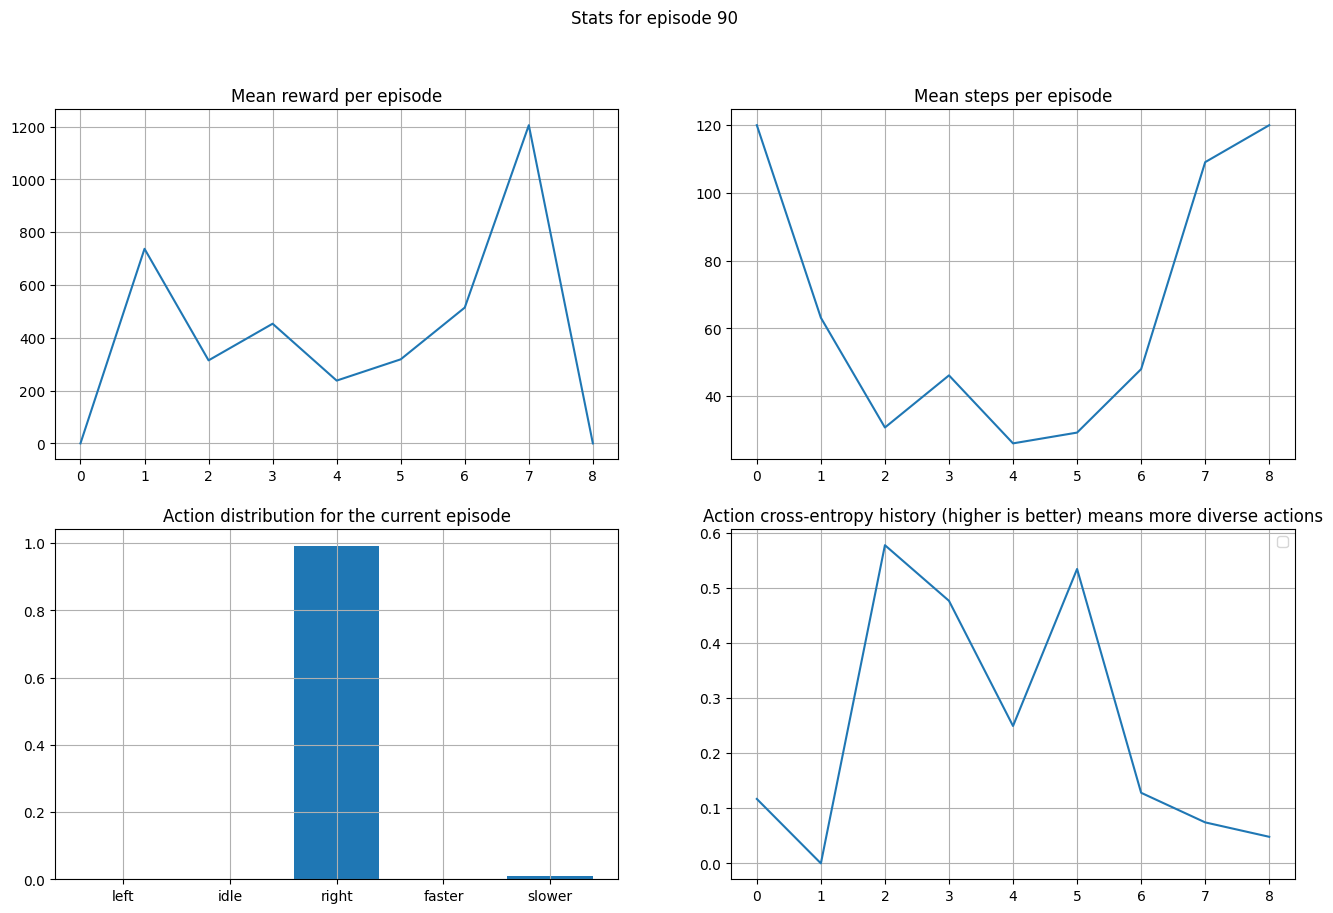

func:'train_model' took: 0.1887 sec
func:'train_model' took: 0.1672 sec
func:'train_model' took: 0.1830 sec
func:'train_model' took: 0.2329 sec
func:'train_model' took: 0.1890 sec
func:'train_model' took: 0.1543 sec
func:'train_model' took: 0.1883 sec
func:'train_model' took: 0.1737 sec
func:'train_model' took: 0.1791 sec
func:'train_model' took: 0.1799 sec
func:'train_model' took: 0.1960 sec
func:'train_model' took: 0.1627 sec
func:'train_model' took: 0.1869 sec
func:'train_model' took: 0.1849 sec
func:'train_model' took: 0.1702 sec
func:'train_model' took: 0.1725 sec
func:'train_model' took: 0.1586 sec
func:'train_model' took: 0.1584 sec
func:'train_model' took: 0.1595 sec
func:'train_model' took: 0.1941 sec
func:'train_model' took: 0.1582 sec
func:'train_model' took: 0.1559 sec
func:'train_model' took: 0.4471 sec
func:'train_model' took: 0.1588 sec
func:'train_model' took: 0.1790 sec
func:'train_model' took: 0.2007 sec
func:'train_model' took: 0.1585 sec
func:'train_model' took: 0.1

In [11]:
ttc_vec_5 = TimeToCollisionVec(num_envs=10,
                            horizon=4,
                            policy_frequency=3,
                            simulation_frequency=20,
                            collision_reward=-120,
                            high_speed_reward=10,
                            right_lane_reward=8,
                            lane_change_reward=3,
                            obs_type='speed-restricted',
                            string_shaped=True)

agent_5 = DQNAgent(ttc_vec_5, model_type='NN_1')

agent_5.init(
    epsilon=1,
    min_eps=0.01,
    eps_decay=0.996,  #.998
    gamma=0.995,
    alpha=0.025,
    replay_memory=50_000,  #50_000
    batch_size=64,   # 64
    train_model_freq=2,
    update_weights_freq=150,
    min_replay_memory=1_000, # 1_000
)

agent_5.train(episodes=1_000,
            episode_duration=25,
            evaluation_freq=10, 
            tolerance=20)

In [ ]:
agent.evaluate_and_render(n_games=3, steps=200)

________________________________________

In [ ]:
config = {
    "observation": {
        "type": "TimeToCollision"
    },
    "vehicles_count": 50,
    "duration": 120,
    "policy_frequency": 5,
    "simulation_frequency": 15
}
env = gym.make("highway-fast-v0")
env.configure(config)
env.reset()

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=1000,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1
)

# Definieren Sie einen Checkpoint-Callback
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./models/', name_prefix='dqn_model')

# Trainieren Sie das Modell
model.learn(total_timesteps=100000, callback=checkpoint_callback)

# Speichern Sie das Modell
model.save("dqn_highway")

# Laden Sie das Modell
model = DQN.load("dqn_highway")


In [ ]:
env = gym.make("highway-fast-v0", render_mode="human", config=config)

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

env.close()